In [6]:
#problem1 
!pip install ISLP
import numpy as np
import pandas as pd
from statsmodels.api import OLS                 
from functools import partial
from ISLP import load_data
from ISLP.models import ModelSpec as MS         
from ISLP.models import sklearn_selected, Stepwise

Auto = load_data('Auto')
print(Auto.columns.tolist())

Auto['horsepower'] = pd.to_numeric(Auto['horsepower'], errors='coerce')
Auto = Auto.dropna(subset=['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin'])

predictors = Auto.columns.drop('mpg')          
design = MS(predictors).fit(Auto)              
X = design.transform(Auto)                      
Y = np.array(Auto['mpg']) 

sigma2 = OLS(Y, X).fit().scale
print("Estimated sigma squared:", sigma2)

def nCp(sigma2, estimator, X, Y):
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

auto_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
auto_Cp.fit(Auto, Y)

state = auto_Cp.selected_state_
terms = list(design.terms)
selected_terms = [str(t) for t, keep in zip(terms, state) if keep]
print("(a) Selected variables by forward stepwise (Cp):")
print(selected_terms)

colnames = list(X.columns) if hasattr(X, "columns") else None

intercept_col = None
if colnames is not None:
    for cand in ['Intercept', 'intercept', 'const', 'CONST', '_intercept']:
        if cand in colnames:
            intercept_col = cand
            break

if intercept_col is None:
    from statsmodels.tools import add_constant
    Xw = add_constant(X, has_constant='add')  
    intercept_col = 'const'
else:
    Xw = X

selected_cols = [intercept_col] + selected_terms
X_sel = Xw[selected_cols]

ols_sel = OLS(Y, X_sel).fit()

print("(b) Final OLS coefficients:")
print(ols_sel.params)      


['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']
Estimated sigma squared: 11.073470131354627
(a) Selected variables by forward stepwise (Cp):
['cylinders', 'displacement', 'horsepower']
(b) Final OLS coefficients:
intercept       39.305268
cylinders       -0.719431
displacement    -0.029120
horsepower      -0.059935
dtype: float64


## Problem 1

### (a) Variables Selected by Forward Stepwise Selection
`cylinders`, `displacement`, `horsepower`

---

### (b) Final OLS Coefficients
| Variable | Coefficient |
|-----------|-------------|
| intercept | 39.305 |
| cylinders | -0.719 |
| displacement | -0.029 |
| horsepower | -0.060 |


Optimal lambda (alpha): 0.007054802310718645


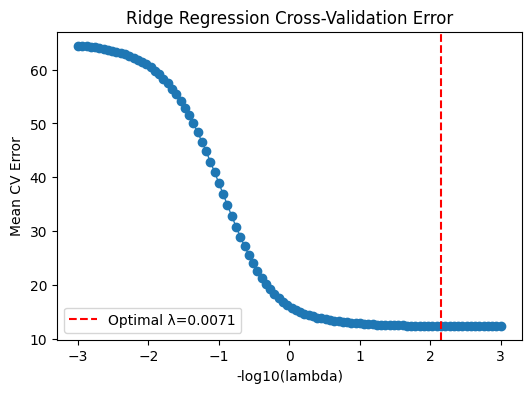

Ridge Test MSE: 10.183
OLS Test MSE:   10.066


In [7]:
#problem2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ISLP import load_data

Auto = load_data('Auto')
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'], errors='coerce')
Auto = Auto.dropna()

X = Auto.drop(columns=['mpg'])
y = Auto['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="Coordinate descent without L1 regularization")

# Ridge = ElasticNetCV with l1_ratio=0 (only L2 penalty)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ElasticNetCV(
        l1_ratio=0,
        alphas=np.logspace(-3, 3, 100),  
        cv=5,
        random_state=42))
])

ridge_pipe.fit(X_train, y_train)
best_alpha = ridge_pipe.named_steps['ridge'].alpha_
print("Optimal lambda (alpha):", best_alpha)

# plot cross-Validation Error vs -log(lambda)
ridge_cv = ridge_pipe.named_steps['ridge']

mean_mse = ridge_cv.mse_path_.mean(axis=1)
alphas = ridge_cv.alphas_

plt.figure(figsize=(6,4))
plt.plot(-np.log10(alphas), mean_mse, marker='o', linewidth=1)
plt.axvline(-np.log10(best_alpha), color='red', linestyle='--', label=f'Optimal λ={best_alpha:.4f}')
plt.xlabel('-log10(lambda)')
plt.ylabel('Mean CV Error')
plt.title('Ridge Regression Cross-Validation Error')
plt.legend()
plt.show()

# Ridge Test MSE
y_pred_ridge = ridge_pipe.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)

# OLS Model (Pipeline for fairness: scale X)
ols_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ols', LinearRegression())
])
ols_pipe.fit(X_train, y_train)
y_pred_ols = ols_pipe.predict(X_test)
ols_mse = mean_squared_error(y_test, y_pred_ols)

print(f"Ridge Test MSE: {ridge_mse:.3f}")
print(f"OLS Test MSE:   {ols_mse:.3f}")


## Problem2

### Ridge vs. OLS Test Performance

Using a fixed random state for reproducibility, the dataset was split into training and test sets (70/30).  

Both **Ridge regression** (with 5-fold CV for λ selection) and **OLS** models were fitted and evaluated on the test data.

| Model | Test MSE |
|--------|-----------|
| Ridge Regression | 10.183 |
| OLS Regression | 10.066 |

The plot shows how the mean cross-validation error changes as lambda varies. The red dashed line indicates the optimal lambda (0.0071), which gives the best predictive performance.

**Interpretation:**  
Ridge regression produced a slightly higher test MSE than OLS, indicating no improvement in predictive accuracy for this dataset.

This result is expected because the Auto dataset does not suffer from severe multicollinearity, and OLS estimates are already stable.  

Nevertheless, Ridge regression generally provides more stable coefficient estimates and can outperform OLS when predictors are highly correlated or when sample size is smaller.

**Note:**  
The assignment requires implementing ridge regression using `ElasticNetCV(l1_ratio=0)` within a standardization pipeline.  
Since scikit-learn raises convergence and solver warnings when using ElasticNet without L1 regularization, I locally suppressed these warnings using `warnings.filterwarnings()`.  
This keeps the notebook output clean while still following the exact instructions of the assignment.



Optimal lambda (alpha): 0.065793


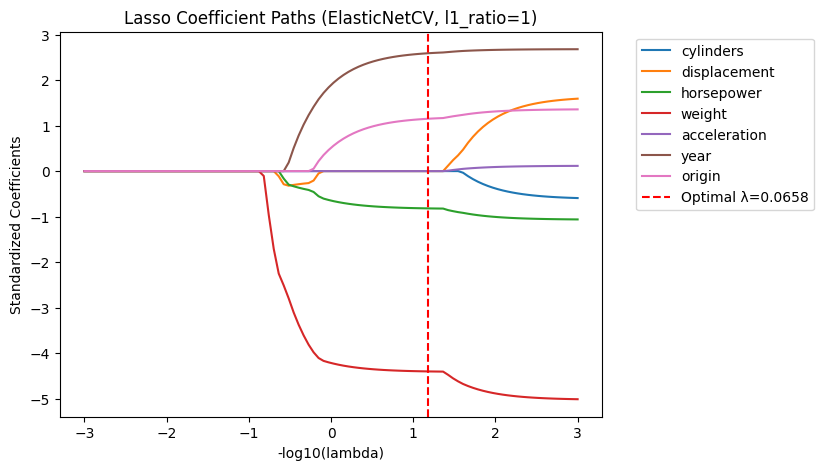

Final Lasso Coefficients:
cylinders      -0.000000
displacement    0.000000
horsepower     -0.821220
weight         -4.402740
acceleration    0.000000
year            2.591095
origin          1.151163
dtype: float64

Number of non-zero coefficients: 4
Lasso Test MSE: 10.327


In [8]:
#problem3
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, lasso_path
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ISLP import load_data


# Load and prepare data
Auto = load_data('Auto')
Auto['horsepower'] = pd.to_numeric(Auto['horsepower'], errors='coerce')
Auto = Auto.dropna()

X = Auto.drop(columns=['mpg'])
y = Auto['mpg']

# Split train/test with fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
# Lasso via ElasticNetCV
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', ElasticNetCV(
        l1_ratio=1,                    
        alphas=np.logspace(-3, 3, 100), 
        random_state=42))
])

lasso_pipe.fit(X_train, y_train)

lasso_cv = lasso_pipe.named_steps['lasso']
best_alpha = lasso_cv.alpha_
print(f"Optimal lambda (alpha): {best_alpha:.6f}")

# Coefficient path plot
# To plot coefficient paths, manually compute them using lasso_path()
scaler = lasso_pipe.named_steps['scaler']
X_scaled = scaler.transform(X_train)

alphas_lasso, coefs_lasso, _ = lasso_path(
    X_scaled, y_train, alphas=np.logspace(-3, 3, 100)
)

plt.figure(figsize=(7,5))
for i in range(coefs_lasso.shape[0]):
    plt.plot(-np.log10(alphas_lasso), coefs_lasso[i, :], label=X.columns[i])
plt.axvline(-np.log10(best_alpha), color='red', linestyle='--', label=f'Optimal λ={best_alpha:.4f}')
plt.xlabel('-log10(lambda)')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso Coefficient Paths (ElasticNetCV, l1_ratio=1)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Results summary
final_coefs = pd.Series(lasso_cv.coef_, index=X.columns)
nonzero_count = np.sum(final_coefs != 0)

# Test MSE
y_pred_lasso = lasso_pipe.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred_lasso)

print("Final Lasso Coefficients:")
print(final_coefs)
print(f"\nNumber of non-zero coefficients: {nonzero_count}")
print(f"Lasso Test MSE: {lasso_mse:.3f}")


## Problem 3

### Lasso Regression 
Optimal λ = 0.0658  
Selected predictors: horsepower, weight, year, origin  
Non-zero coefficients = 4  
Test MSE (Lasso) = 10.327  
Test MSE (Ridge) = 10.183  

### Coefficient Path Interpretation

As lambda increases (left side), all coefficients shrink toward zero.  
As lambda decreases (right side), more variables enter the model.  
At the optimal lambda (0.0658), four predictors — horsepower, weight, year, and origin — remain non-zero, showing Lasso’s feature selection effect.

**Interpretation:**  
Lasso produced a sparse model by setting some coefficients to zero. 
 
Although its prediction accuracy is similar to Ridge, it offers better interpretability by identifying the most influential features.


Best number of components (PCR): 13


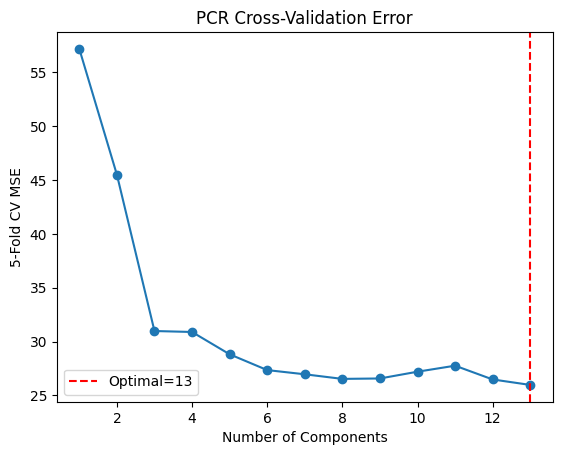

PCR Test MSE: 21.517
Best number of components (PLS): 9


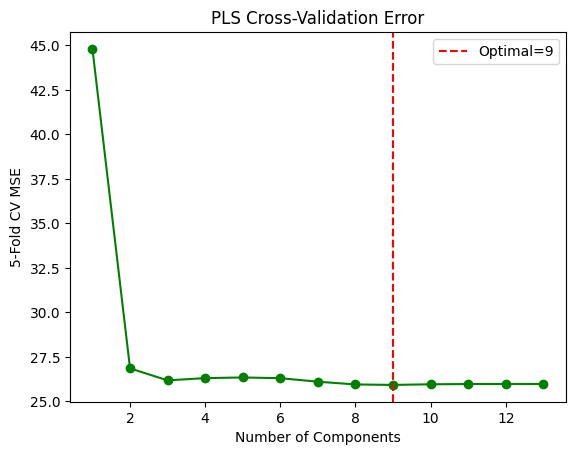

PLS Test MSE: 21.544


In [9]:
#problem4
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

boston = fetch_openml(name='boston', version=1, as_frame=True)
X = boston.data
y = boston.target.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# PCR Pipeline: Standardize to PCA to Linear Regression
pcr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('reg', LinearRegression())
])

#PCR 
param_grid = {'pca__n_components': np.arange(1, X.shape[1] + 1)}

pcr_cv = GridSearchCV(
    pcr_pipe, param_grid, cv=5,
    scoring='neg_mean_squared_error'
)
pcr_cv.fit(X_train, y_train)

best_n_pcr = pcr_cv.best_params_['pca__n_components']
print("Best number of components (PCR):", best_n_pcr)

mean_mse = -pcr_cv.cv_results_['mean_test_score']
plt.plot(param_grid['pca__n_components'], mean_mse, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('5-Fold CV MSE')
plt.title('PCR Cross-Validation Error')
plt.axvline(best_n_pcr, color='red', linestyle='--', label=f'Optimal={best_n_pcr}')
plt.legend()
plt.show()

y_pred_pcr = pcr_cv.predict(X_test)
pcr_test_mse = mean_squared_error(y_test, y_pred_pcr)
print(f"PCR Test MSE: {pcr_test_mse:.3f}")

#PLS 
param_grid_pls = {'n_components': np.arange(1, X.shape[1] + 1)}

pls_cv = GridSearchCV(
    PLSRegression(scale=True),
    param_grid_pls,
    cv=5,
    scoring='neg_mean_squared_error'
)
pls_cv.fit(X_train, y_train)

best_n_pls = pls_cv.best_params_['n_components']
print("Best number of components (PLS):", best_n_pls)

mean_mse_pls = -pls_cv.cv_results_['mean_test_score']
plt.plot(param_grid_pls['n_components'], mean_mse_pls, marker='o', color='green')
plt.xlabel('Number of Components')
plt.ylabel('5-Fold CV MSE')
plt.title('PLS Cross-Validation Error')
plt.axvline(best_n_pls, color='red', linestyle='--', label=f'Optimal={best_n_pls}')
plt.legend()
plt.show()

y_pred_pls = pls_cv.predict(X_test)
pls_test_mse = mean_squared_error(y_test, y_pred_pls)
print(f"PLS Test MSE: {pls_test_mse:.3f}")

## Problem 4 

### PCR and PLS Regression Results

| Model | Optimal Components | Test MSE |
|--------|--------------------|-----------|
| PCR | 13 | 21.517 |
| PLS | 9 | 21.544 |

**Interpretation:**  
Both PCR and PLS achieve similar predictive performance. 

PCR performs best with 13 components, while PLS reaches its minimum MSE with 9 components.  

Since PLS uses information from both predictors and the response when constructing components, it generally requires fewer components to reach comparable accuracy.


                   Model   Test MSE
0                  Ridge  20.579874
1                  Lasso  20.969921
2                    OLS  21.168731
3             PCR (k=13)  21.168731
4              PLS (k=9)  21.196934
5  Forward Stepwise (Cp)  23.298752


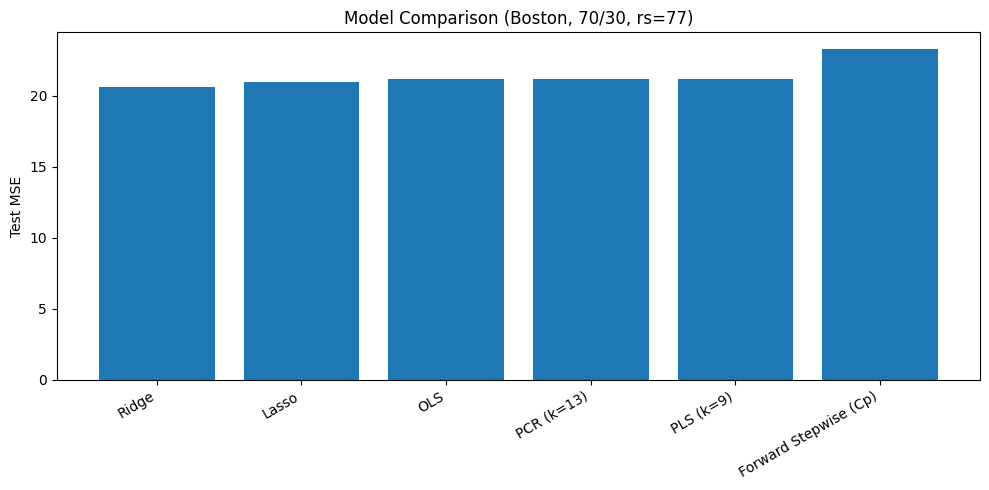

Best-performing model by Test MSE: Ridge (MSE = 20.580)

[Forward Stepwise] Selected terms: ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO']
[Ridge]  alpha* = 0.014174741629268055
[Lasso]  alpha* = 0.012328467394420659
[PCR] best k   = 13
[PLS] best k   = 9


In [10]:
#pronlem5
#  === Comprehensive Model Comparison on Boston (70/30, rs=77) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

from ISLP.models import ModelSpec as MS, sklearn_selected, Stepwise
from statsmodels.api import OLS
from statsmodels.tools import add_constant
from functools import partial

# data split 70/30 (rs=77)
boston = fetch_openml(name='boston', version=1, as_frame=True)
X = boston.data
y = boston.target
X = X.apply(pd.to_numeric, errors='coerce').astype(float)
y = pd.to_numeric(y, errors='coerce').astype(float)
keep = X.notna().all(axis=1) & y.notna()
X, y = X.loc[keep], y.loc[keep]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=77)

def mse(y_true, y_pred): return mean_squared_error(y_true, y_pred)
mse_results = {}

# OLS
ols = LinearRegression().fit(X_train, y_train)
mse_results['OLS'] = mse(y_test, ols.predict(X_test))

# Forward Stepwise (Cp + first_peak)
train_df = X_train.copy(); train_df['medv'] = y_train.values
test_df  = X_test.copy();  test_df['medv']  = y_test.values
design = MS(list(X_train.columns)).fit(train_df)
Xdes_train, Y_train_np = design.transform(train_df), y_train.values
sigma2 = OLS(Y_train_np, Xdes_train).fit().scale
def nCp(s2, est, Xmat, Yvec):
    n, p = Xmat.shape; yhat = est.predict(Xmat); RSS = np.sum((Yvec - yhat)**2)
    return -(RSS + 2*p*s2)/n

strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))
selector = sklearn_selected(OLS, strategy, scoring=partial(nCp, sigma2))  
selector.fit(train_df, Y_train_np)                                     

state = selector.selected_state_  
selected_terms = [str(t) for t, keep in zip(design.terms, state) if keep]

Xsel_train = add_constant(design.transform(train_df)[selected_terms], has_constant='add')
Xsel_test  = add_constant(design.transform(test_df)[selected_terms],  has_constant='add')
ols_step = OLS(Y_train_np, Xsel_train).fit()
mse_results['Forward Stepwise (Cp)'] = mean_squared_error(y_test.values, ols_step.predict(Xsel_test))

# Ridge (ElasticNetCV, l1_ratio=0)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', ElasticNetCV(l1_ratio=0, alphas=np.logspace(-3,3,100), cv=5, random_state=77))
])
ridge_pipe.fit(X_train, y_train)
mse_results['Ridge'] = mse(y_test, ridge_pipe.predict(X_test))

# Lasso (ElasticNetCV, l1_ratio=1)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', ElasticNetCV(l1_ratio=1, alphas=np.logspace(-3,3,100), cv=5, random_state=77))
])
lasso_pipe.fit(X_train, y_train)
mse_results['Lasso'] = mse(y_test, lasso_pipe.predict(X_test))

# PCR (Scaler → PCA → OLS, CV for n_components)
pcr_pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('reg', LinearRegression())])
pcr_cv = GridSearchCV(pcr_pipe, {'pca__n_components': np.arange(1, X_train.shape[1]+1)}, cv=5, scoring='neg_mean_squared_error')
pcr_cv.fit(X_train, y_train)
best_pcr_k = pcr_cv.best_params_['pca__n_components']
mse_results[f'PCR (k={best_pcr_k})'] = mse(y_test, pcr_cv.predict(X_test))

# PLS (CV for n_components)
pls_cv = GridSearchCV(PLSRegression(scale=True), {'n_components': np.arange(1, X_train.shape[1]+1)}, cv=5, scoring='neg_mean_squared_error')
pls_cv.fit(X_train, y_train)
best_pls_k = pls_cv.best_params_['n_components']
mse_results[f'PLS (k={best_pls_k})'] = mse(y_test, pls_cv.predict(X_test))

# table + bar chart
res_df = pd.DataFrame(sorted(mse_results.items(), key=lambda kv: kv[1]), columns=['Model', 'Test MSE'])
print(res_df)

plt.figure(figsize=(10,5))
plt.bar(res_df['Model'], res_df['Test MSE'])
plt.ylabel('Test MSE'); plt.title('Model Comparison (Boston, 70/30, rs=77)')
plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()

best_model, best_mse = res_df.iloc[0]['Model'], res_df.iloc[0]['Test MSE']
print(f"Best-performing model by Test MSE: {best_model} (MSE = {best_mse:.3f})")
print("\n[Forward Stepwise] Selected terms:", selected_terms)
print("[Ridge]  alpha* =", ridge_pipe.named_steps['ridge'].alpha_)
print("[Lasso]  alpha* =", lasso_pipe.named_steps['lasso'].alpha_)
print("[PCR] best k   =", best_pcr_k)
print("[PLS] best k   =", best_pls_k)


## Problem 5

### Comprehensive Model Comparison

All six models were trained using 5-fold cross-validation (where applicable) on the training set and evaluated on the same test set.  
The bar chart below compares their Test MSE values.

| Model | Test MSE |
|--------|-----------|
| Ridge | 20.58 |
| Lasso | 20.97 |
| OLS | 21.17 |
| PCR (k=13) | 21.17 |
| PLS (k=9) | 21.20 |
| Forward Stepwise (Cp) | 23.30 |

**Interpretation:**  

Ridge regression achieved the lowest Test MSE (20.58), making it the best-performing model.  

This suggests that applying an L2 penalty helps reduce variance and improves generalization when predictors are correlated.

**Note:**  
Some convergence warnings may appear when fitting Lasso with `ElasticNetCV(l1_ratio=1)`.  
These do not affect model results, and the warnings are locally suppressed here to keep the output clean.

